In [1]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from pyedflib import highlevel
from sklearn.decomposition import PCA, FastICA
import numpy as np
import os
import mne
from tqdm.auto import tqdm
from srcs.preprocessing import retrieve_data, parse_filter_data
PATH='/mnt/nfs/homes/thoberth/sgoinfre/physionet.org/files/eegmmidb/1.0.0/'

In [2]:
data = retrieve_data(PATH)


  0%|          | 0/40 [00:00<?, ?it/s]

# Separate both type of labels and standardize value

In [3]:
### Must optimize this part of preprocessing

dataT1, dataT2 = parse_filter_data(data.copy(), 'mne')
# del data
dataT1.shape, dataT2.shape

mne normalisation ...
<class 'numpy.ndarray'> (64, 8286720)


((3133, 7232), (3156, 7232))

## Prepare data

In [4]:
from sklearn.model_selection import train_test_split
T1Len = dataT1.shape

X = np.concatenate((dataT1, dataT2), axis = 0)
Y = np.array([1 if i < T1Len[0] else 0 for i in range(X.shape[0])])

# Show explained variance for each number of component

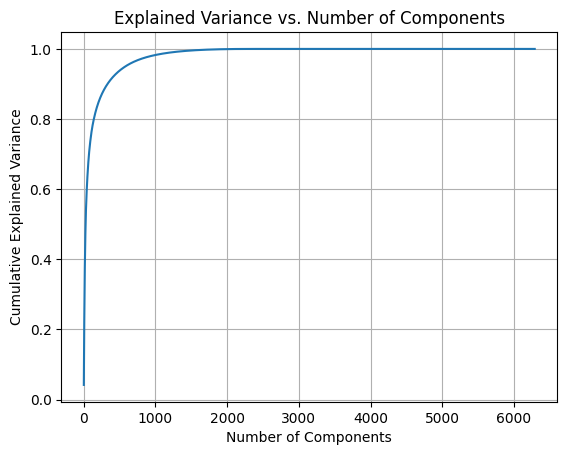

In [5]:
pca = PCA().fit(X)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

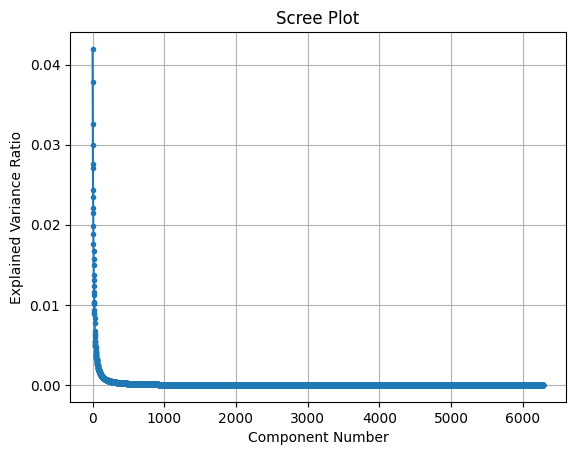

In [6]:
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 'o-', markersize=3)
plt.xlabel('Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(True)

plt.show()

# Define the n components after analysis

In [7]:
n_components = 150

# Dimension Reduction

In [8]:
XReducted = PCA(n_components=n_components).fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(XReducted, Y, test_size=0.15, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5345, 150) (5345,) (944, 150) (944,)


# Dimension reduction using CSP

In [13]:
# from mne.decoding import CSP

# Classification Algo

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd

# RandomForestClassifier

In [10]:
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print("Score de precisions :", accuracy_score(y_test, y_pred))

Score de precisions : 0.5180084745762712


# LogisticRegression

In [11]:
classifier = LogisticRegression(random_state=42, verbose=True)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print("Score de precisions :", accuracy_score(y_test, y_pred))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  3.46118D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  151      2      4      1     0     0   2.347D-06   6.931D-01
  F =  0.69312322058070075     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Score de precisions : 0.4925847457627119


 This problem is unconstrained.


# SVC

In [12]:
classifier = SVC(random_state=42, verbose=True)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print("Score de precisions :", accuracy_score(y_test, y_pred))

[LibSVM]...*.*
optimization finished, #iter = 4207
obj = -4021.742460, rho = -0.014064
nSV = 5291, nBSV = 4351
Total nSV = 5291
Score de precisions : 0.5413135593220338


# Now lets create a real pipeline for training